1. Тестируем работу YOLOv5 на собственном датасете

In [ ]:
!pip install TerraYolo

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from TerraYolo.TerraYolo import TerraYoloV5
import IPython.display as ipd

In [ ]:
# Задание имени рабочего каталога
TRAIN_DIR = '/content/my_yolov5/'

# Создание рабочего каталога
os.mkdir(TRAIN_DIR)

In [ ]:
# Подключаем Гугл диск
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Распаковка архива собственного датасета
!unzip -q -o /content/drive/MyDrive/2_стажировка_Каски/Датасет/Kaski_2.v3i.yolov5pytorch.zip  -d {TRAIN_DIR}

In [ ]:
# Задание пути к yaml-файлу
data_path = TRAIN_DIR+'data.yaml' #сохраним путь к файлу в отдельную переменную

# Просмотр содержимого yaml-файла
!cat {data_path}

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['Hardhat', 'NO-Hardhat', 'Person']

roboflow:
  workspace: sergey-shishkin-kifgq
  project: kaski_2
  version: 3
  license: Public Domain
  url: https://universe.roboflow.com/sergey-shishkin-kifgq/kaski_2/dataset/3

In [ ]:
# Выведем количество файлов в рабочих директориях
print(len(os.listdir(TRAIN_DIR+'train/images/')))
print(len(os.listdir(TRAIN_DIR+'train/labels/')))
print(len(os.listdir(TRAIN_DIR+'valid/images/')))
print(len(os.listdir(TRAIN_DIR+'valid/labels/')))

900
900
31
31


In [ ]:
my_terra_yolov5 = TerraYoloV5(work_dir=TRAIN_DIR)
# Вывод числа объектов в датасете
my_terra_yolov5.count_labels(data_path)

lab_dir /content/my_yolov5/train/labels
в каталоге /content/my_yolov5/train/labels найдены описания: [1281  210 1506] классов: [0 1 2]
lab_dir /content/my_yolov5/valid/labels
в каталоге /content/my_yolov5/valid/labels найдены описания: [40  7 51] классов: [0 1 2]
каталог /content/my_yolov5/test/labels не найден


In [ ]:
# Обучение
train_dict=dict()
train_dict['epochs'] = 10
train_dict['data'] = data_path

In [ ]:
# в режиме 'train' запустим обучение с задаными параметрами
my_terra_yolov5.run(train_dict, exp_type='train')

command python /content/my_yolov5/yolov5/train.py --epochs 10 --data /content/my_yolov5/data.yaml
2023-12-04 17:43:26.731643: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 17:43:26.731693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 17:43:26.731726: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=my_yolov5/yolov5/yolov5s.pt, cfg=, data=/content/my_yolov5/data.yaml, hyp=my_yolov5/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, e

In [ ]:
# Валидация

val_dict=dict()
val_dict['data'] = data_path

val_dict['weights'] = '/content/best.pt'
my_terra_yolov5.run(val_dict, exp_type='val')

command python /content/my_yolov5/yolov5/val.py --data /content/my_yolov5/data.yaml --weights /content/best.pt
val: data=/content/my_yolov5/data.yaml, weights=['/content/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=my_yolov5/yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers...
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
100%|██████████| 755k/755k [00:00<00:00, 21.5MB/s]
val: Scanning /content/my_yolov5/valid/labels... 31 images, 4 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 422.94it/s]
val: New cache created: /content/my_yolov5/valid/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:

img_path /content/my_yolov5/yolov5//runs/val//exp


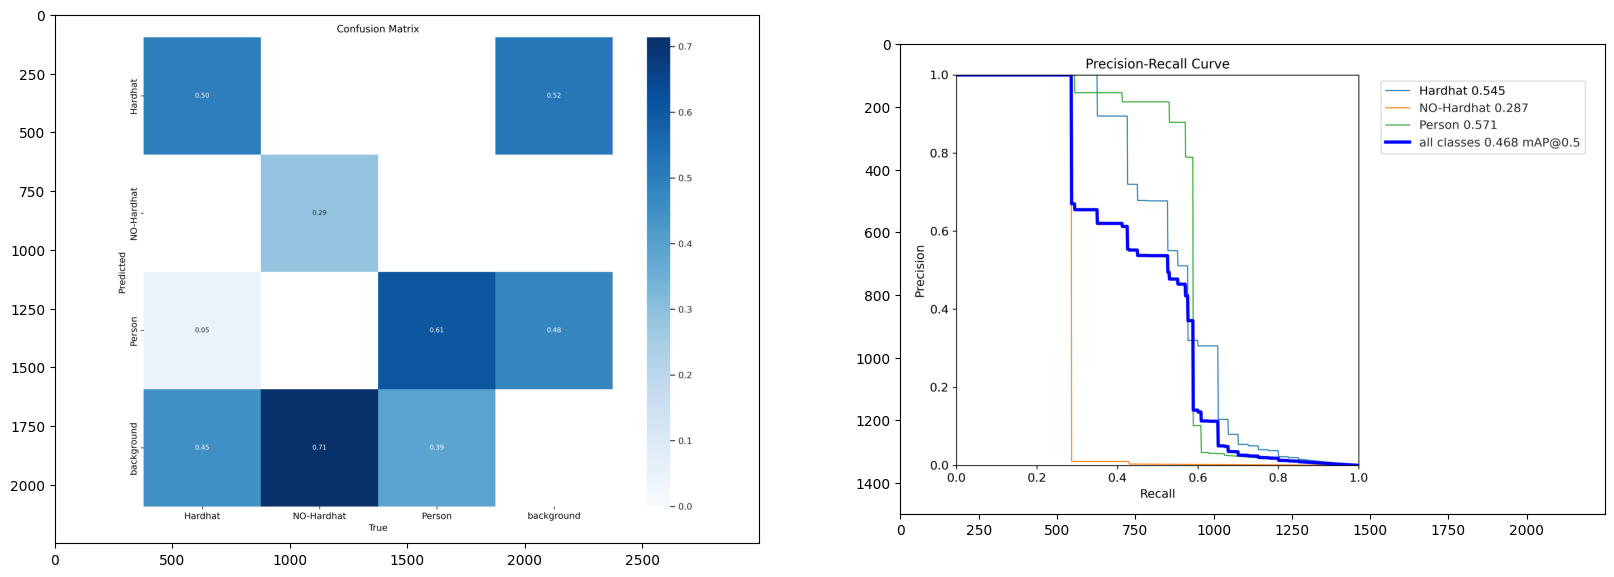

In [ ]:
my_terra_yolov5.show_val_results(img_path=None, img_list=['confusion_matrix.png', 'PR_curve.png'])

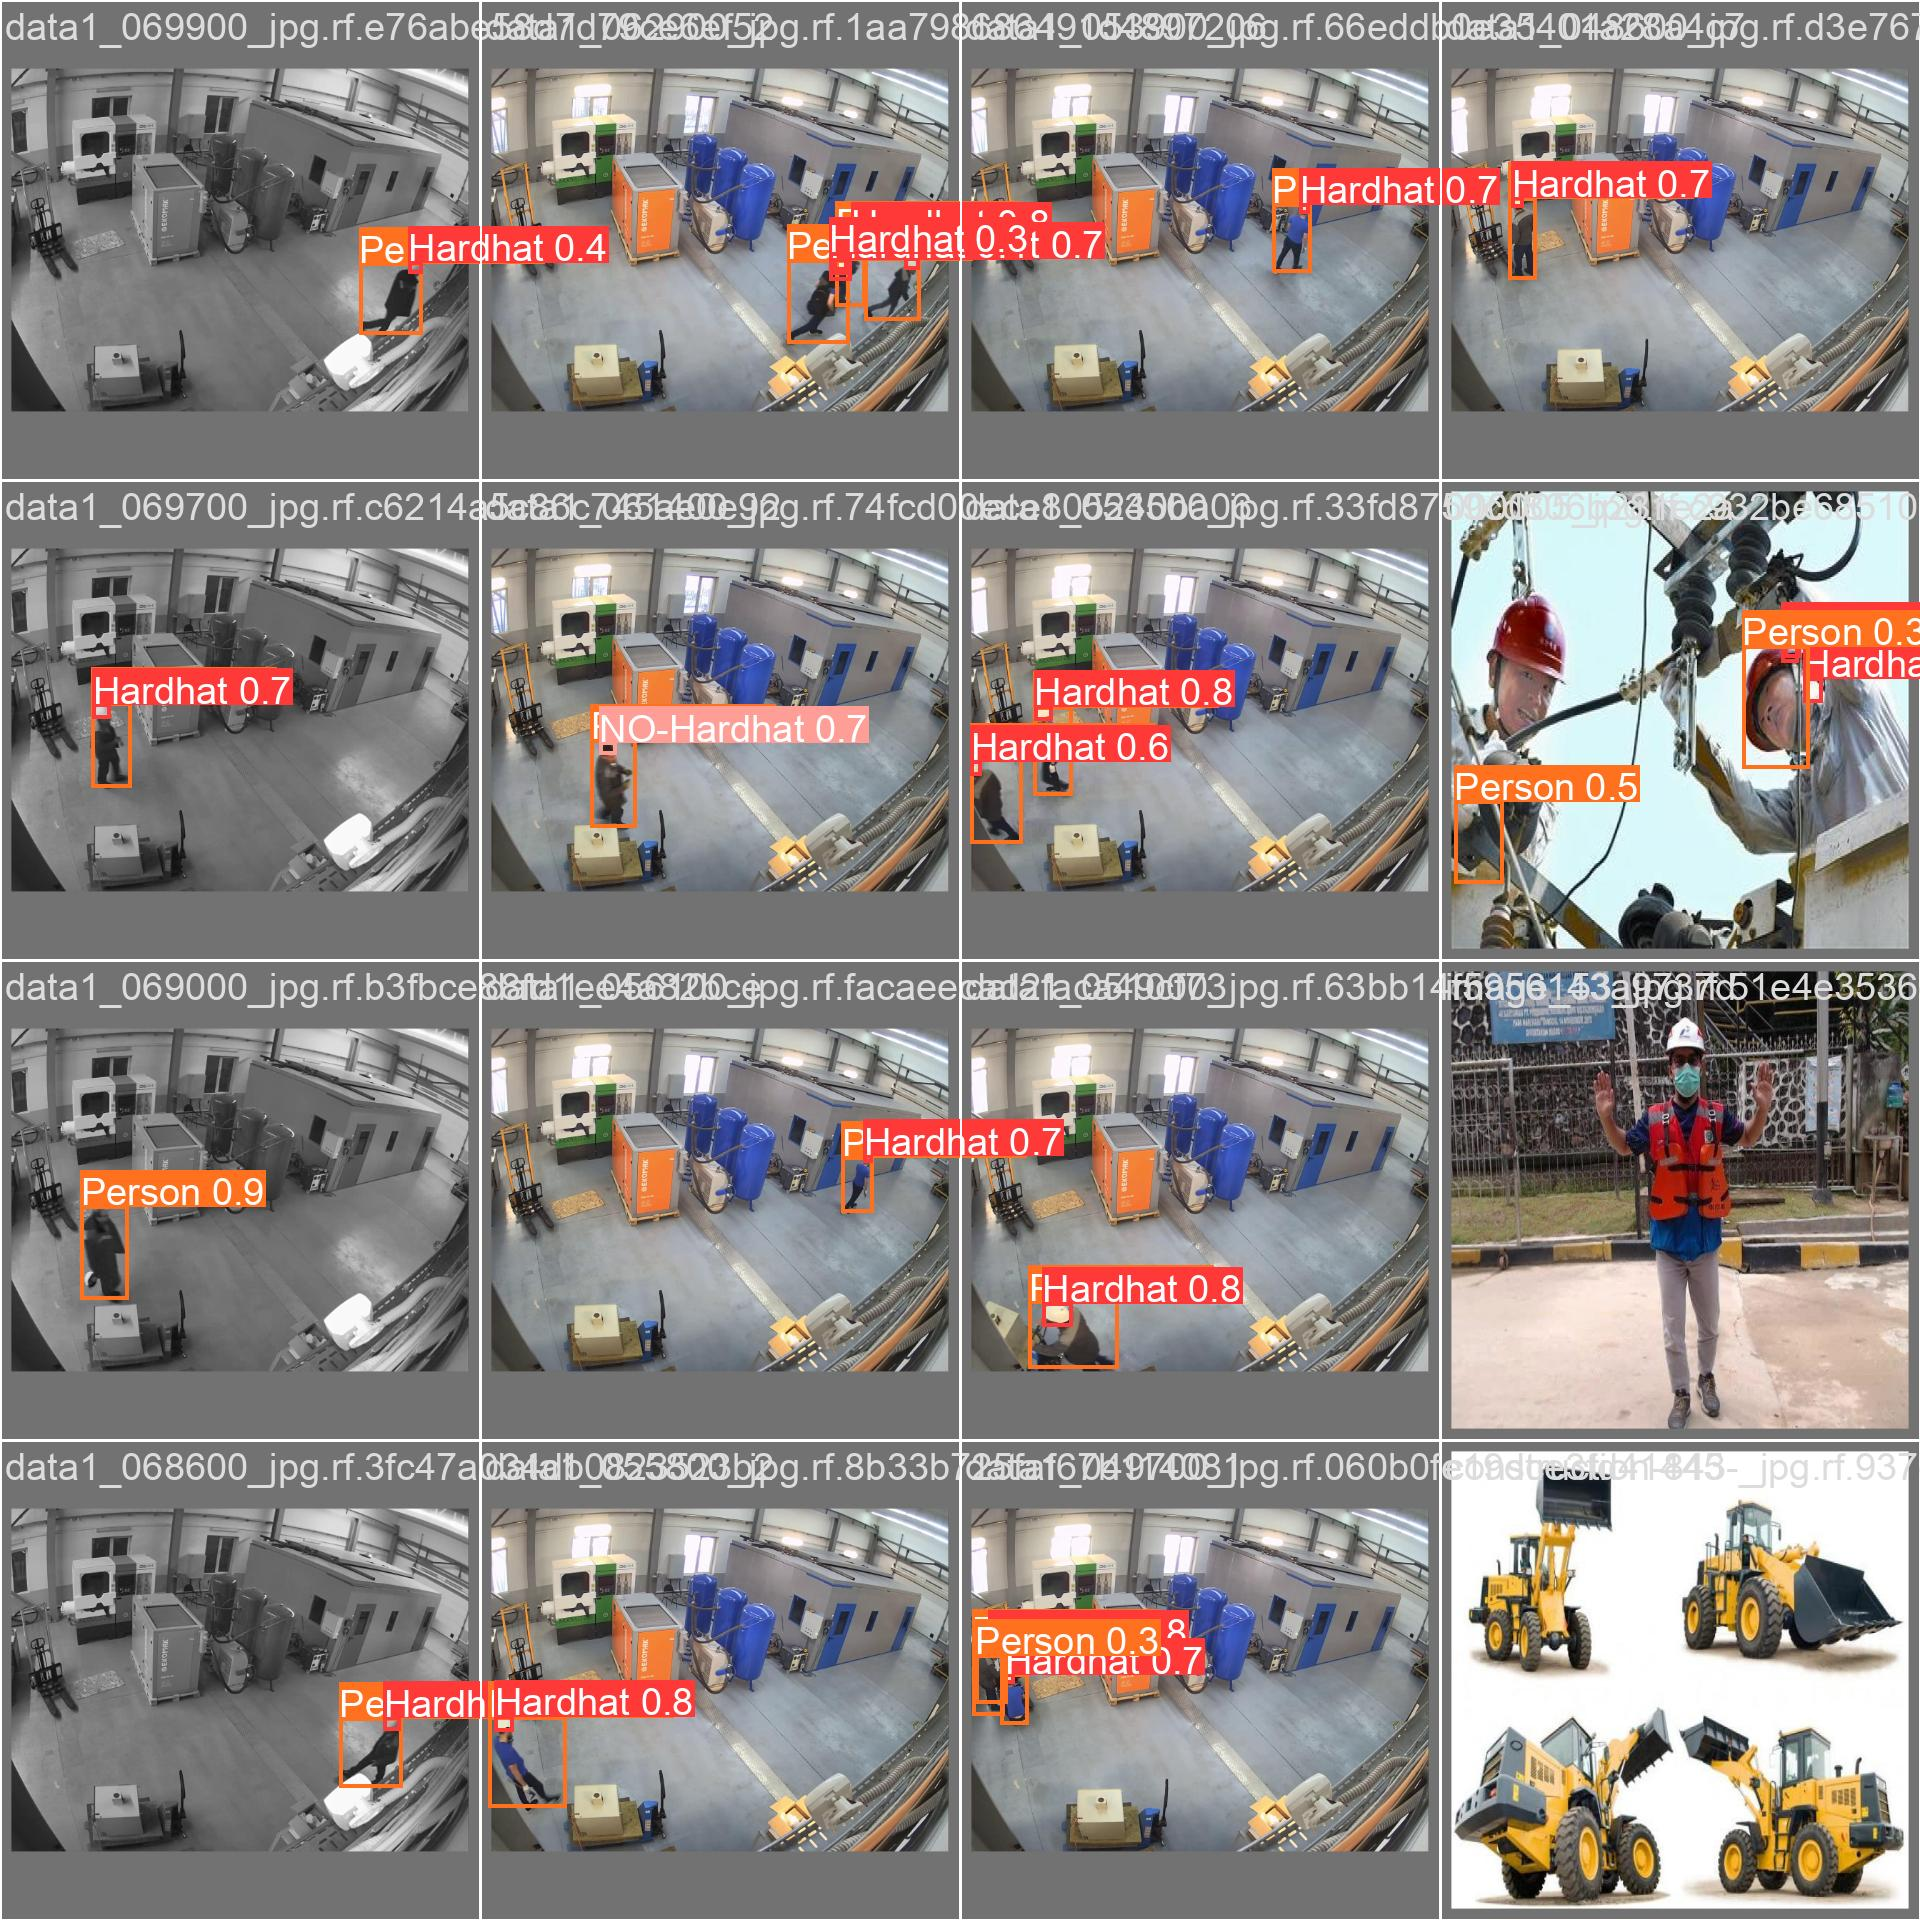

In [ ]:
image1 = ipd.Image('/content/my_yolov5/yolov5/runs/val/exp/val_batch0_labels.jpg')

image1

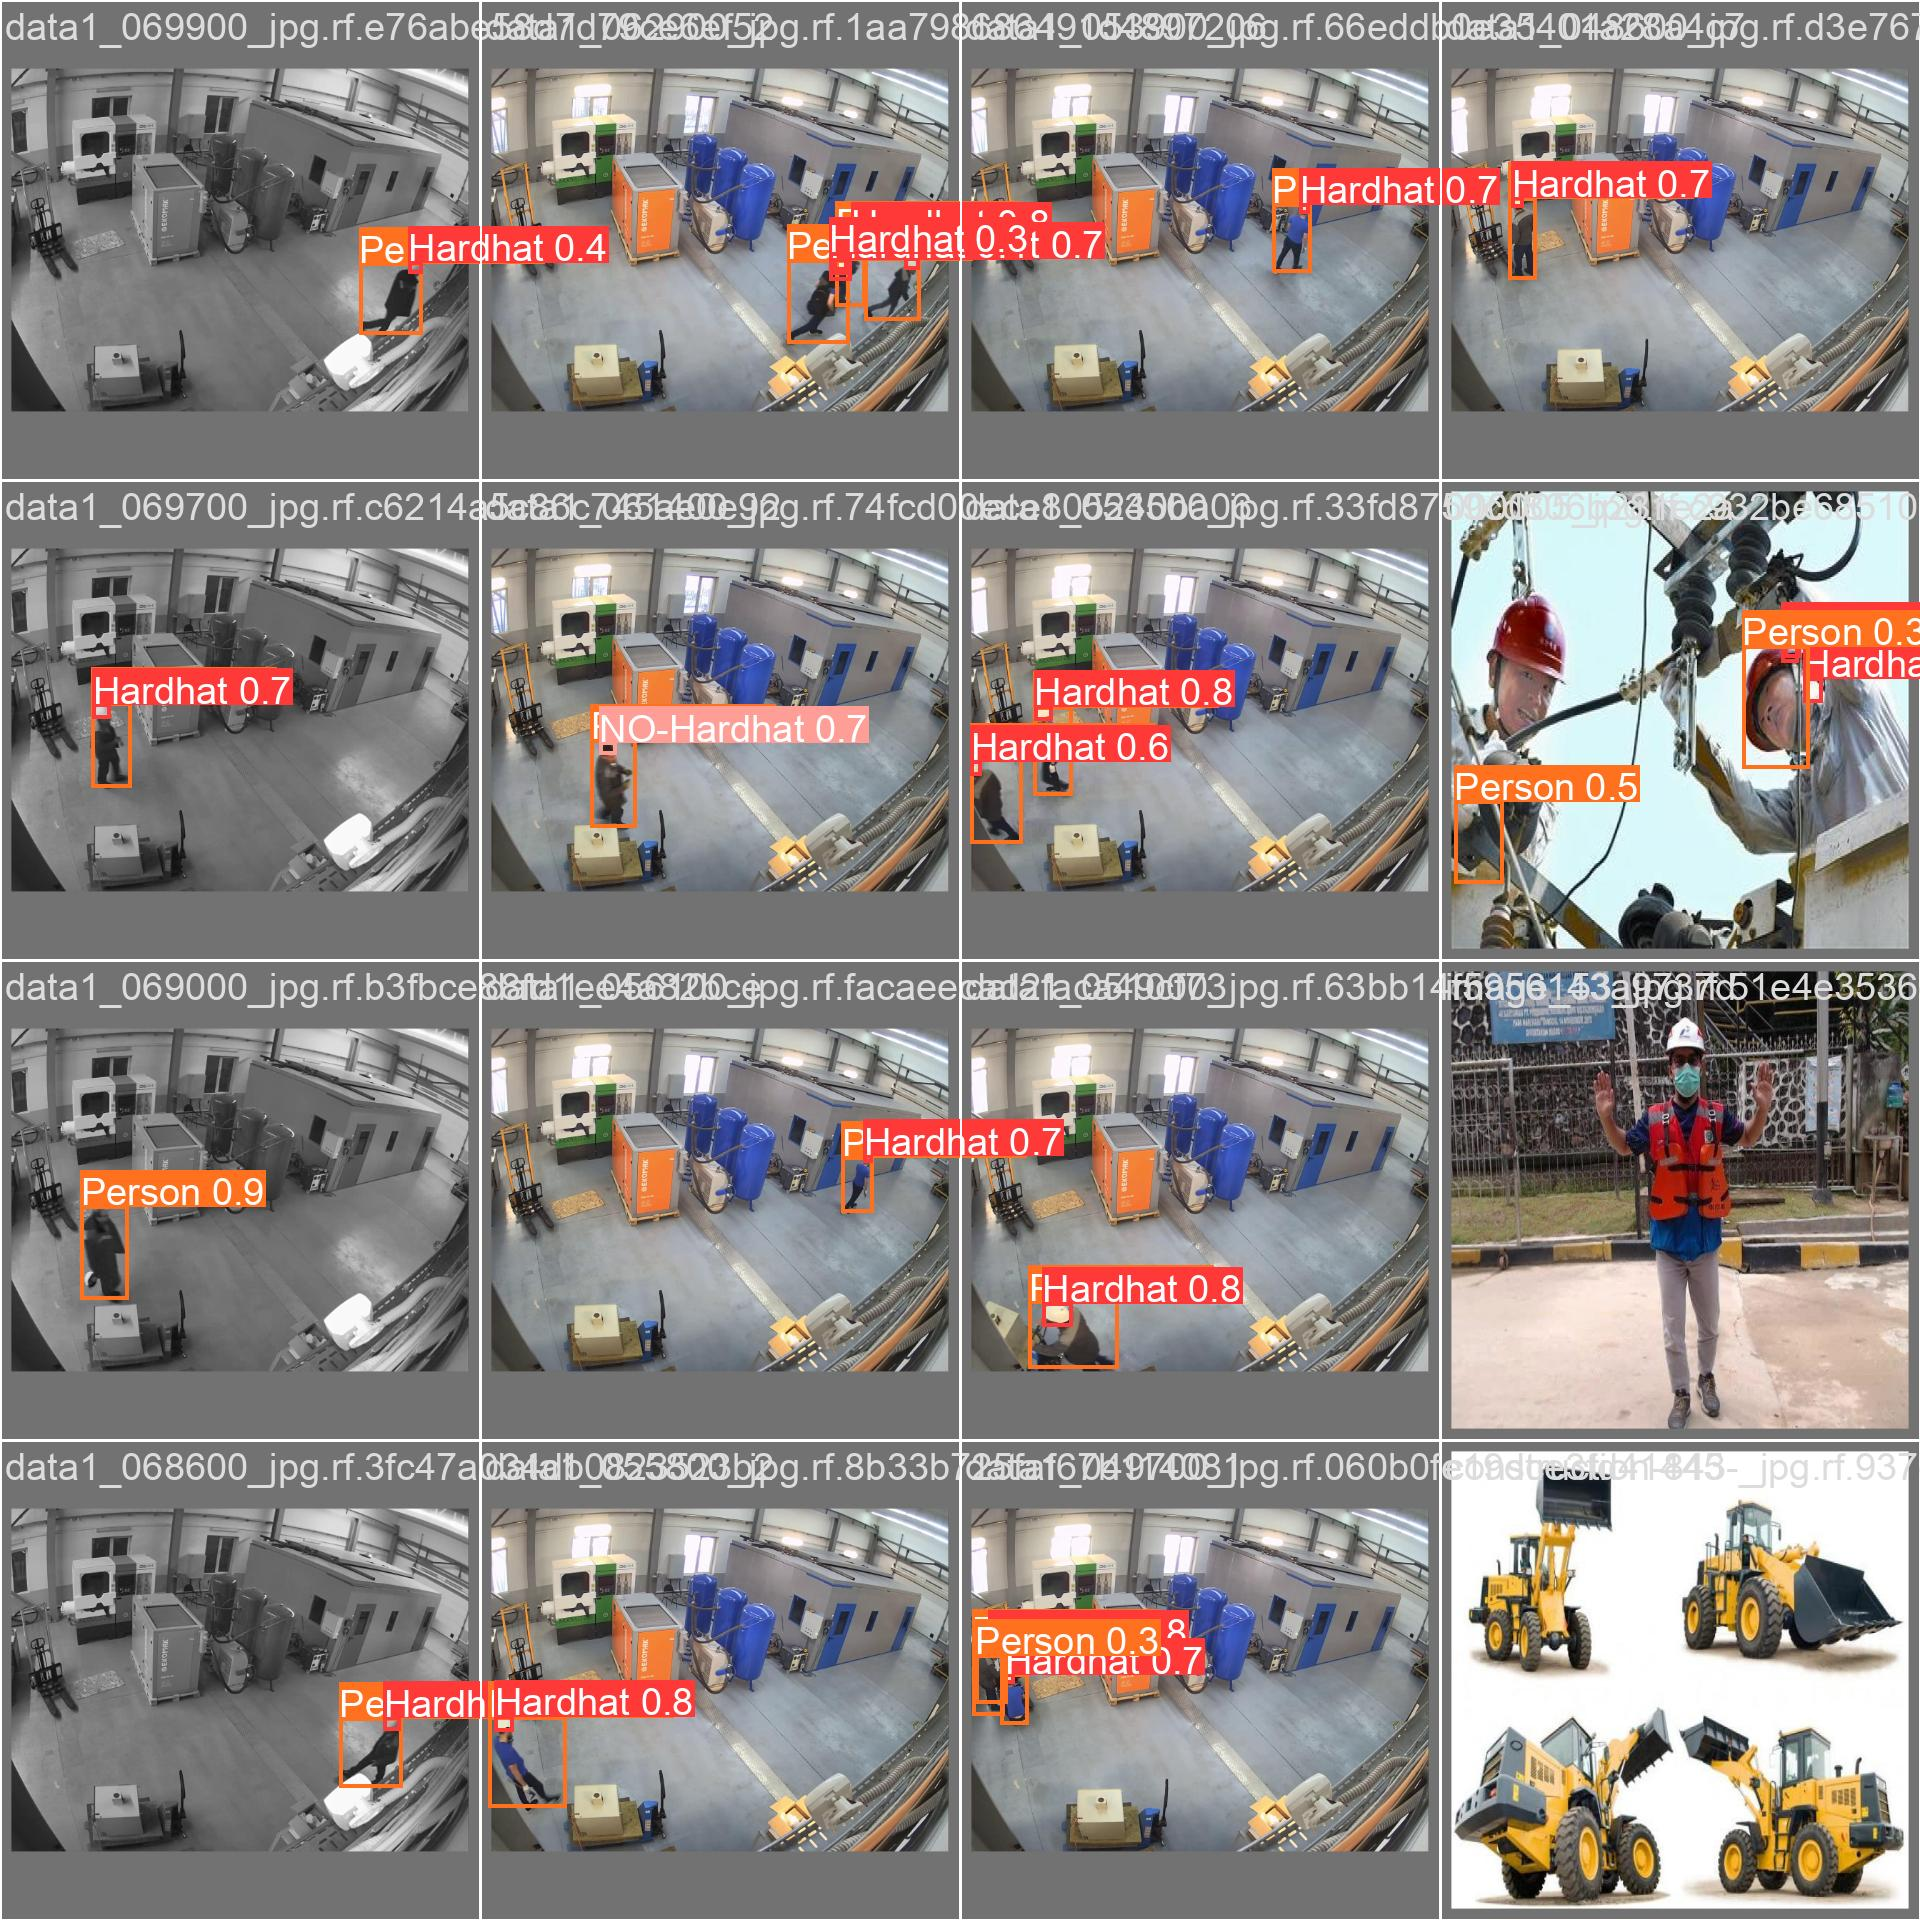

In [ ]:
image2 = ipd.Image('/content/my_yolov5/yolov5/runs/val/exp/val_batch0_pred.jpg')
# Отобразите изображение
image2

In [ ]:
# Детекция на видео
!pip -q install ffmpeg-python

In [ ]:
import ffmpeg
from base64 import b64encode
from IPython.display import HTML

In [ ]:
test_dict = dict()
test_dict['source'] = '/content/drive/MyDrive/2_стажировка_Каски/Датасет/test_v.avi' # укажем путь к тестовому видео
test_dict['conf'] = 0.5 # порог вероятности обнаружения объекта
test_dict['weights'] = '/content/best.pt'

my_terra_yolov5.run(test_dict, exp_type='test')

command python /content/my_yolov5/yolov5/detect.py --source /content/drive/MyDrive/2_стажировка_Каски/Датасет/test_v.avi --conf 0.5 --weights /content/best.pt
detect: weights=['/content/best.pt'], source=/content/drive/MyDrive/2_стажировка_Каски/Датасет/test_v.avi, data=my_yolov5/yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=my_yolov5/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers...
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/18001) /content/drive/MyDrive/2_стажировка_Каски/Датасет/test_v.avi: 480x640 1 Hardhat, 1 Person, 481.0ms
video 1/1 (2/1800

In [ ]:
from moviepy.editor import VideoFileClip


video = VideoFileClip('/content/my_yolov5/yolov5/runs/detect/exp2/test_v.mp4').subclip(0, 60)

# Отображение видео
display(video.ipython_display())

t:   4%|▎         | 110/3000 [04:06<02:14, 21.42it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4




t:   4%|▎         | 110/3000 [05:39<02:14, 21.42it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
!pip -q install ffmpeg-python

In [ ]:
import ffmpeg
from base64 import b64encode
from IPython.display import HTML

In [ ]:
!rm -rf outputh264.mp4
input_path = '/content/__temp__.mp4'
output_path = 'outputh264.mp4'

# Конвертируем видео в кодек H.264
ffmpeg.input(input_path).output(output_path, vcodec="libx264").run()

# Генерируем ссылку для HTML5-видеоплеера
video_file = open(output_path, "rb").read()
video_url = "data:video/mp4;base64," + b64encode(video_file).decode()

# Выводим видео
display(HTML(f'<video width=1600 controls><source src="{video_url}" type="video/mp4"></video>'))